# Fair Data Challenge

In this project, we will analyze a dataset containing historical data on loan borrowers. The goal of this project is to build a predictive model predicting the loan default of potential defaulters.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
plt.style.use('dark_background')# for styles


# Loading Data from CSV into data frame
loan_data = pd.read_csv("train_data.csv", low_memory = False) #low memory to avoid fixed types column error

In [2]:
loan_data.head()

,id,loan_status,mths_since_last_major_derog,revol_bal,purpose,addr_state,title,home_ownership,application_type,verification_status_joint,earliest_cr_line,apply_date,verification_status,emp_length,dti,emp_title,annual_inc
0,63480419,Current,NaN,15954,debt_consolidation,KS,Debt consolidation,MORTGAGE,INDIVIDUAL,NaN,5-Aug,15-Nov,Not Verified,5 years,24.85,Branch Office Administrator,62000.0
1,51386490,Current,NaN,73814,debt_consolidation,MD,Debt consolidation,MORTGAGE,INDIVIDUAL,NaN,Sep-83,15-Jun,Verified,10+ years,26.38,IIntelligence Analyst,113000.0
2,13567696,Current,NaN,30013,major_purchase,TX,Major purchase,OWN,INDIVIDUAL,NaN,Dec-99,14-Apr,Not Verified,10+ years,14.41,Global Service Delivery Lead,180000.0
3,22252931,Fully Paid,NaN,10768,credit_card,DE,Credit card refinancing,MORTGAGE,INDIVIDUAL,NaN,1-Sep,14-Jul,Not Verified,10+ years,24.31,Operations Manager,66000.0
4,6539569,Fully Paid,NaN,35551,home_improvement,WI,Home Improvement,MORTGAGE,INDIVIDUAL,NaN,Dec-92,13-Aug,Verified,2 years,1.70,Coram Specialty Infusion,110000.0


In [3]:
loan_data.shape

(200000, 17)

# Question 1:  

Perform any data cleaning and exploratory analysis that you feel is appropriate.Summarize your approach in a few sentences and report some interesting facts about the population in the data.

**Approach for the above problem**

- Cleanned variables and converted to the required format
- Dropped categorical vairables which added no value to prediction
- Dropped vairables with more than 80% missing values
- Checked for correlation and skewness
- Performed feature engineering
- Identified important variables using random forest
- One hot encoded categorical variables

In [4]:
loan_data.describe()

,id,mths_since_last_major_derog,revol_bal,dti,annual_inc
count,2.000000e+05,49745.000000,2.000000e+05,200000.000000,1.999980e+05
mean,3.243004e+07,44.136134,1.692455e+04,18.146953,7.519197e+04
std,2.282037e+07,22.258667,2.165016e+04,23.809379,6.343685e+04
min,5.574200e+04,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,9.197932e+06,27.000000,6.440000e+03,11.890000,4.500000e+04
50%,3.441335e+07,44.000000,1.188600e+04,17.620000,6.500000e+04
75%,5.488857e+07,62.000000,2.084525e+04,23.890000,9.000000e+04
max,6.861676e+07,180.000000,1.190046e+06,9999.000000,7.500000e+06


**Target Variable Cleaning**

loan_status is the target variable in our problem.

In [5]:
statusByType = loan_data.groupby('loan_status').size()
statusByType

loan_status
Charged Off                                             10270
Current                                                135528
Default                                                   288
Does not meet the credit policy. Status:Charged Off       160
Does not meet the credit policy. Status:Fully Paid        452
Fully Paid                                              46837
In Grace Period                                          1411
Issued                                                   1919
Late (16-30 days)                                         509
Late (31-120 days)                                       2626
dtype: int64

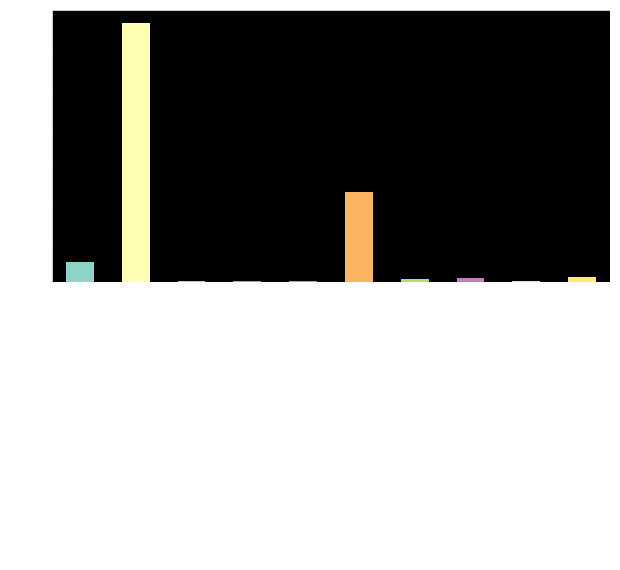

In [24]:
plot=[]
plot.append(10) # nubmer of possible target variables
plot.append(5) # split in the Y axis
plt.rcParams["figure.figsize"] = plot
statusByType.plot(kind='bar')


As our aim is to predict the defaulters, the target variable which is not used in our prediction model are about to get removed from the instances.

So, we are removing the instances with target output
* Current
* Issued
* Late

In [7]:
filter_data= loan_data['loan_status'].isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off',
                                        'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid'])
loan_new_data = loan_data[filter_data]
loan_new_data.groupby('loan_status').size()

loan_status
Charged Off                                            10270
Default                                                  288
Does not meet the credit policy. Status:Charged Off      160
Does not meet the credit policy. Status:Fully Paid       452
Fully Paid                                             46837
dtype: int64

Now seperating the entire category into two 
**Defaulters and Non-Defaulters**

In [8]:
loan_new_data['output'] = np.where(loan_new_data['loan_status'].isin(['Default', 'Charged Off',
                                                                      'Does not meet the credit policy. Status:Charged Off']),'Defaulters', 'Non-Defaulters')
output=loan_new_data.groupby('output').size()
output

c:\users\monis\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


output
Defaulters        10718
Non-Defaulters    47289
dtype: int64

array(['INDIVIDUAL'], dtype=object)

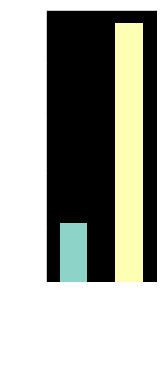

In [9]:
plot=[]
plot.append(2) # nubmer of possible target variables
plot.append(5) # split in the Y axis
plt.rcParams["figure.figsize"] = plot
output.plot(kind='bar')
loan_new_data["application_type"].unique()

Now we will considering about the **Missing Values**

In [10]:
loan_new_data.isnull().sum()

id                                 0
loan_status                        0
mths_since_last_major_derog    47390
revol_bal                          0
purpose                            0
addr_state                         0
title                              3
home_ownership                     0
application_type                   0
verification_status_joint      58007
earliest_cr_line                  11
apply_date                         0
verification_status                0
emp_length                      2301
dti                                0
emp_title                       3247
annual_inc                         2
output                             0
dtype: int64

In [11]:
loan_new_data.shape

(58007, 18)

Creating the below function to remove the features having more than 80% of NA values

In [12]:
def dropMoreNA(dataframe):
    t = dataframe
    columnsRemoved = []
    column_names = t.columns.values
    for i in column_names:
        try:
            if t[i].isnull().sum() > 46000: 
                columnsRemoved.append(i)
                t.drop(labels=i, axis=1, inplace=True)
        except ValueError:
            pass
    return t, columnsRemoved

In [13]:
loan_new_data, dropped_Columns = dropMoreNA(loan_new_data)
loan_new_data.shape

c:\users\monis\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(58007, 16)

In [14]:
dropped_Columns

['mths_since_last_major_derog', 'verification_status_joint']

In [15]:
loan_new_data.head()

,id,loan_status,revol_bal,purpose,addr_state,title,home_ownership,application_type,earliest_cr_line,apply_date,verification_status,emp_length,dti,emp_title,annual_inc,output
3,22252931,Fully Paid,10768,credit_card,DE,Credit card refinancing,MORTGAGE,INDIVIDUAL,1-Sep,14-Jul,Not Verified,10+ years,24.31,Operations Manager,66000.0,Non-Defaulters
4,6539569,Fully Paid,35551,home_improvement,WI,Home Improvement,MORTGAGE,INDIVIDUAL,Dec-92,13-Aug,Verified,2 years,1.70,Coram Specialty Infusion,110000.0,Non-Defaulters
7,7047928,Fully Paid,40836,debt_consolidation,OH,Debt Consolidation,MORTGAGE,INDIVIDUAL,Jun-99,13-Sep,Not Verified,6 years,19.86,STERIS,98005.0,Non-Defaulters
9,1060578,Fully Paid,25237,debt_consolidation,RI,debt,RENT,INDIVIDUAL,4-Jun,11-Dec,Not Verified,10+ years,20.01,citizens bank,55000.0,Non-Defaulters
10,28604357,Fully Paid,17469,debt_consolidation,SD,Debt consolidation,RENT,INDIVIDUAL,Jul-96,14-Oct,Source Verified,10+ years,16.76,Sr. Research Analyst,71500.0,Non-Defaulters


NEXTSTEP:
some of the columns are not related to our target variable and some of them are redundant. 
We are going to remove those columns from the dataframe.

In [16]:
del_col = ["id","loan_status","purpose", "addr_state","title","emp_title","earliest_cr_line","apply_date","emp_title"] 
dataset = loan_new_data.drop(labels = del_col, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (58007, 8)


In [17]:
dataset.head()

,revol_bal,home_ownership,application_type,verification_status,emp_length,dti,annual_inc,output
3,10768,MORTGAGE,INDIVIDUAL,Not Verified,10+ years,24.31,66000.0,Non-Defaulters
4,35551,MORTGAGE,INDIVIDUAL,Verified,2 years,1.70,110000.0,Non-Defaulters
7,40836,MORTGAGE,INDIVIDUAL,Not Verified,6 years,19.86,98005.0,Non-Defaulters
9,25237,RENT,INDIVIDUAL,Not Verified,10+ years,20.01,55000.0,Non-Defaulters
10,17469,RENT,INDIVIDUAL,Source Verified,10+ years,16.76,71500.0,Non-Defaulters


NEXT STEP: emp_length column

In [18]:
dataset["emp_length"] = dataset["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0','nan':'0'}, regex = True)

In [19]:
dataset["application_type"].unique()

array(['INDIVIDUAL'], dtype=object)

application type is not having the JOINT type beacuse of the fact that those records with joint account is removed when we removed
* Current
* Issued
* Late

SO there is no use for the application type in our data set

In [20]:
dataset = dataset.drop(labels = "application_type", axis = 1) 

In [21]:
dataset.head()

,revol_bal,home_ownership,verification_status,emp_length,dti,annual_inc,output
3,10768,MORTGAGE,Not Verified,10,24.31,66000.0,Non-Defaulters
4,35551,MORTGAGE,Verified,2,1.70,110000.0,Non-Defaulters
7,40836,MORTGAGE,Not Verified,6,19.86,98005.0,Non-Defaulters
9,25237,RENT,Not Verified,10,20.01,55000.0,Non-Defaulters
10,17469,RENT,Source Verified,10,16.76,71500.0,Non-Defaulters


Saving the final data frame into csv that we can use for the next model.

In [22]:
dataset.to_csv("final_training.csv", sep=',', encoding='utf-8',index = False)

# Final Summary after data cleaning part

    As per our EDA analysis and data cleansing part we conclude that 'revol_bal', 'home_ownership', 'verification_status', 'emp_length','dti', 'annual_inc' are the important features that helps to buid our prediction model.



**The primary issue is that the above given CSV is an Imbalanced dataset.**


In our case banks want to predict the defaulters for loan.Practically in these cases, only a small fraction of observations are actually positives i.e defaulters output. 


the probablity of the defaulters in our data base is very less compared to the non defaulters. 


**SO we need to oversample the minority class observations to improve the quality of predictive modeling. **

Oversampling can lead to the models  to learn patterns that differentiate different possible classes.


# Next Part


I am going to upsample the default cases by using the **Synthetic Minority Oversampling Technique.**